In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

from matplotlib import gridspec
from IPython.display import HTML

plt.xkcd()

HTML("""
<style>
.toggle_box {
    position: fixed;
    align: center;
    padding: 2px;
    top: 17%;
    left: 96%;
    opacity: 0.6;
    z-index: 10000;
}
.toggle_button {
    padding: 1px 3px 0 1px;
}
</style>

<script>
var code_show = true;

function code_toggle() {
  if (code_show) {
    $('div.input').hide('linear');
    $('img#code-toggle')
      .attr('src', 'assets/expand.png')
      .attr('title', 'click to display code cells');
  } else {
    $('div.input').show('linear');
    $('img#code-toggle')
      .attr('src', 'assets/collapse.png')
      .attr('title', 'click to hide code cells');
  }
  code_show = !code_show;
}
</script>

<div class='toggle_box'>
  <button class='toggle_button' onclick='javascript:code_toggle()'>
    <img id='code-toggle' src='assets/collapse.png' title='click to hide code cells'/>
  </button>
</div>""")

# Gradient Descent for Linear Regression

## Introduction

In machine learning, gradient descent is used to optimize a cost function, by measuring the difference between a prediction $\hat{y}$ given by a hypothesis function $h_{\theta}$ and the actual value $y$. This difference between $h_{\theta}$ and $y$ is modelled with cost function $J(\theta)$.

Optimizing $J(\theta)$ helps us find a set of model parameters $\theta$ that predict $y$ with the least amount of error.

In terms of the graph below, gradient descent tries to find values for parameter $\theta_{0}$ and $\theta_{1}$ that minimize the cost surface $J(\theta)$.

![gradient descent](assets/3Dsurface.png "What values for parameter θ₀ and θ₁ minimize the cost surface J(θ)?")

The notebook gives a very brief example of using gradient descent in linear regression.

This example will cover:

1. exploratory data analysis
1. deciding on a hypothesis function
1. deriving the corresponding cost function and gradient function
1. implement gradient descent
1. confirm and visualize the results

The code in our example uses:

* [NumPy](http://www.numpy.org/) - a package for scientific / mathematical computing
* [Pandas](http://pandas.pydata.org/) - a Python data analysis library

----

## Data Exploration

We begin by loading our data on file into a [`pandas.Dataframe`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

We can get a better idea about the data by using [`pandas.DataFrame.shape`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html), [`pandas.DataFrame.head`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html), [`pandas.DataFrame.tail`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.tail.html), and [`pandas.DataFrame.describe`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html)

In [2]:
data = pd.read_csv('data/ex1data1.txt',
                   header=None,
                   names=['x', 'y'])

print('The shape of our dataframe:\n{} rows, {} columns\n'.format(*data.shape))

print('Here are the first 10 rows:\n{}\n'.format(data.head(10)))

print('Here are the last 10 rows:\n{}\n'.format(data.tail(10)))

print('Some descriptive statistics about our dataset:\n{}'.format(data.describe()))

The shape of our dataframe:
97 rows, 2 columns

Here are the first 10 rows:
        x        y
0  6.1101  17.5920
1  5.5277   9.1302
2  8.5186  13.6620
3  7.0032  11.8540
4  5.8598   6.8233
5  8.3829  11.8860
6  7.4764   4.3483
7  8.5781  12.0000
8  6.4862   6.5987
9  5.0546   3.8166

Here are the last 10 rows:
          x        y
87   6.0020  0.92695
88   5.5204  0.15200
89   5.0594  2.82140
90   5.7077  1.84510
91   7.6366  4.29590
92   5.8707  7.20290
93   5.3054  1.98690
94   8.2934  0.14454
95  13.3940  9.05510
96   5.4369  0.61705

Some descriptive statistics about our dataset:
               x          y
count  97.000000  97.000000
mean    8.159800   5.839135
std     3.869884   5.510262
min     5.026900  -2.680700
25%     5.707700   1.986900
50%     6.589400   4.562300
75%     8.578100   7.046700
max    22.203000  24.147000


Visualizing the data as $x,y$ coordinates in a scatter plot will help us decide on a hypothesis function for our model.

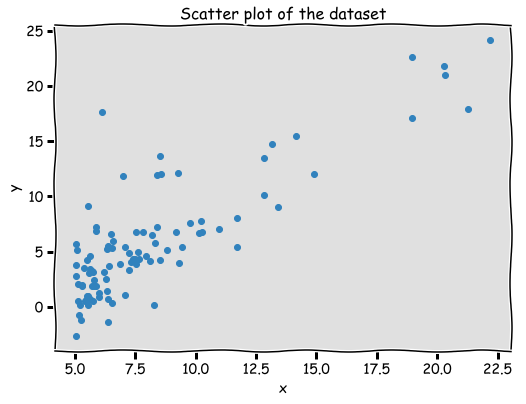

In [3]:
plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])
graph0 = plt.subplot(gs[0])
graph0.scatter(data.x, data.y, color='#3182bd')
graph0.set_xlabel('x', fontsize=14)
graph0.set_ylabel('y', fontsize=14)
graph0.set_title(r'Scatter plot of the dataset', fontsize=16)
graph0.set_facecolor('0.88')

----

### Linear regression and hypothesis function $h_{\theta}$

We would like to derive a model where, given a new value $x$, we could confidently predict the corresponding $y$. Gaining a clue from the scatter plot above, perhaps a _line that best fits the points in our data set_ will serve as the hypothesis function for our model.

Recall that the slope-intercept formula for a straight line is


>\begin{align}
  y &= b + mx
\end{align}

The model we are looking for can then be represented with the following hypothesis function:

>\begin{align}
  h_{\theta}(x) &= \theta_{0} + \theta_{1}x
\end{align}

The model parameter in question, called collectively $\theta$, are:
* $\theta_{0}$, $y$-intercept
* $\theta_{1}$, slope $m$

But how do we go about finding appropriate values for $\theta$ that will provide us the best possible model?

### Computing cost function $J(\theta)$



In [4]:
def cost(theta, X, y):
    theta = np.matrix(theta)
    
    m = X.shape[0]
    
    y_hat = np.dot(X, theta.T).sum(axis=1)
    
    cost = np.square(y_hat - y).sum() / (2*m)
    
    return cost

In [5]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    
    m = X.shape[0]
    
    y_hat = np.dot(X, theta.T).sum(axis=1)
    err = (y_hat - y).ravel()
    
    deriv_0 = (1./m) * np.multiply(err, X[:, 0]).sum()
    deriv_1 = (1./m) * np.multiply(err, X[:, 1]).sum()
    
    return deriv_0, deriv_1

In [6]:
NUM_ITERS = 10000   # number of iterations for gradient descent
ALPHA = 1e-2        # step size scaling

def gradient_descent(theta, X, y):
    m = X.shape[0]
    
    cost_history = np.zeros(shape=(NUM_ITERS, 1))
    
    theta_history = np.zeros(shape=(NUM_ITERS, 2))
    
    for i in range(NUM_ITERS):
        deriv_0, deriv_1 = gradient(theta, X, y)
        
        theta[0] -= ALPHA * deriv_0
        theta[1] -= ALPHA * deriv_1
        
        theta_history[i, 0] = theta[0]
        theta_history[i, 1] = theta[1]
        
        cost_history[i,0] = cost(theta, X, y)
        
    return theta, cost_history, theta_history

In [7]:
# prepare training data, add bias column
X = data.values[:, 0:1]
X = np.insert(X, 0, np.ones(X.shape[1]), axis=1)

y = data.values[:, 1:2]

theta = np.zeros(2)

print('Here are the first 5 rows of the training data:\n{}'.format(X[0:5, :]))

Here are the first 5 rows of the training data:
[[ 1.      6.1101]
 [ 1.      5.5277]
 [ 1.      8.5186]
 [ 1.      7.0032]
 [ 1.      5.8598]]


In [8]:
print('With the following initial θ values:')
print(r'θ₀ (y-intercept): {}'.format(theta[0]))
print(r'θ₁ (slope): {}'.format(theta[1]))
print('initial cost = {}'.format(cost(theta, X, y)))

With the following initial θ values:
θ₀ (y-intercept): 0.0
θ₁ (slope): 0.0
initial cost = 32.072733877455676


In [9]:
theta, cost_history, theta_history = gradient_descent(theta, X, y)

print('After {} iterations of gradient descent:'.format(NUM_ITERS))
print(r'θ₀ (y-intercept): {}'.format(theta[0]))
print(r'θ₁ (slope): {}'.format(theta[1]))
print('final cost = {}'.format(cost(theta, X, y)))

After 10000 iterations of gradient descent:
θ₀ (y-intercept): -3.8957808202682354
θ₁ (slope): 1.1930336383584825
final cost = 4.476971375975179


In [10]:
# predict y value for x = 3.5 (adding in bias node value +1)
predict1 = np.array([1, 3.5]).dot(theta)
print('For x = 3.5, our model predicts y = {}'.format(predict1))

# predict y value for x = 7.0 (adding in bias node value +1)
predict2 = np.array([1, 7.0]).dot(theta)
print('For x = 7.0, our model predicts y = {}'.format(predict2))

For x = 3.5, our model predicts y = 0.2798369139864536
For x = 7.0, our model predicts y = 4.455454648241142


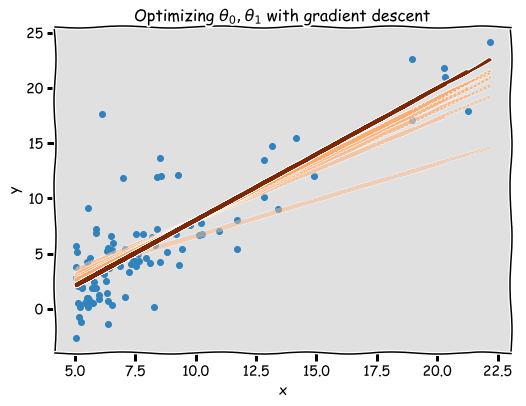

In [11]:
fx = theta_history[:, 0]
fb = theta_history[:, 1]

plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])

# scatter plot
graph0 = plt.subplot(gs[0])
graph0.scatter(X[:,1:2], y, color='#3182bd')

for e in zip([0, 200, 400, 600, 800, 100], [0.3, 0.4, 0.5, 0.6, 0.7]):
    i, a = e
    graph0.plot(data.values[:, 0:1],
                X.dot([fx[i], fb[i]]).flatten(),
                color='#fd8d3c',
                alpha=a,
                ls=':')

result = X.dot(theta).flatten()
graph0.plot(data.values[:,0:1], result, color='#7f2704')

graph0.set_xlabel(r'x', fontsize=14)
graph0.set_ylabel(r'y', fontsize=14)
graph0.set_title(r'Optimizing $\theta_0, \theta_1$ with gradient descent',
                 fontsize=16)
graph0.set_facecolor('0.88')


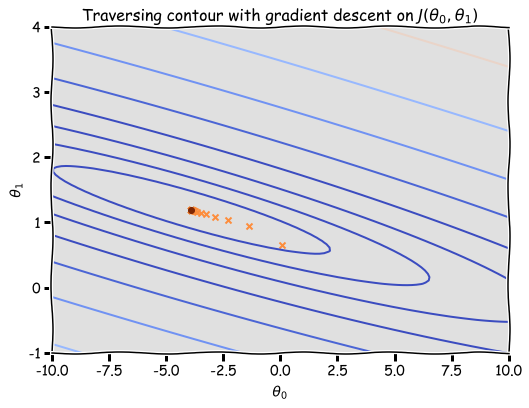

In [12]:
plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])

theta0_vals = np.linspace(-10, 10, 100)
theta1_vals = np.linspace(-1, 4, 100)

J_vals = np.zeros(shape=(theta0_vals.size, theta1_vals.size))

for t1, e1 in enumerate(theta0_vals):
    for t2, e2 in enumerate(theta1_vals):
        thetaT = np.zeros(2)
        thetaT[0] = e1
        thetaT[1] = e2
        J_vals[t1,t2] = cost(thetaT, X,  y)

J_vals = J_vals.T

graph1 = plt.subplot(gs[0])

levels = np.logspace(-2, 3, 20).size
colormap = plt.cm.get_cmap('coolwarm', levels-1)

plt.contour(theta0_vals,
            theta1_vals,
            J_vals,
            np.logspace(-2, 3, 20),
            cmap=colormap)

mymap = plt.get_cmap('PuBuGn')
mycolors = mymap(cost_history[0::250].flatten())

graph1.set_xlabel(r'$\theta_0$', fontsize=14)
graph1.set_ylabel(r'$\theta_1$', fontsize=14)
graph1.scatter(fx[0::250], fb[0::250], marker='x', c='#fd8d3c')
graph1.scatter(theta[0], theta[1], color='#7f2704')
graph1.set_title(r'Traversing contour with gradient descent on $J(\theta_0,\theta_1)$',
                 fontsize=16)
graph1.set_facecolor('0.88')


In [13]:
from scipy.optimize import minimize

res = minimize(cost,
               np.zeros(2),
               args=(X,y),
               method='TNC',
               jac=gradient)

print('Using scipy.optimize.minimize(method="TNC") function:')
print(r'θ₀ (y-intercept): {}'.format(res.x[0]))
print(r'θ₁ (slope): {}'.format(res.x[1]))
print('cost = {}'.format(cost(res.x, X, y)))

Using scipy.optimize.minimize(method="TNC") function:
θ₀ (y-intercept): -3.8957806990210218
θ₁ (slope): 1.1930336281990377
cost = 4.4769713759751815


In [14]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X[:, 1:2], y)

theta0 = lr.intercept_.flatten()[0]
theta1 = lr.coef_.flatten()[0]

print('Using sklearn.linear_mode.LinearRegression:')
print(r'θ₀ (y-intercept): {}'.format(theta0.item()))
print(r'θ₁ (slope): {}'.format(theta1))
print('cost = {}'.format(cost([theta0, theta1], X, y)))


Using sklearn.linear_mode.LinearRegression:
θ₀ (y-intercept): -3.8957808783118537
θ₁ (slope): 1.193033644189594
cost = 4.476971375975179


In [15]:
gramian = np.linalg.inv(np.dot(X.T, X))
moment = np.dot(X.T, y)

mpp_theta = np.dot(gramian, moment)

print('Using OLS (Moore-Penrose pseudoinverse):')
print(r'θ₀ (y-intercept): {}'.format(mpp_theta[0].item()))
print(r'θ₁ (slope): {}'.format(mpp_theta[1].item()))
print('cost = {}'.format(cost(mpp_theta.reshape((2)), X, y)))


Using OLS (Moore-Penrose pseudoinverse):
θ₀ (y-intercept): -3.895780878311868
θ₁ (slope): 1.1930336441895961
cost = 4.476971375975179


----